# SI 618 - Homework #2: More Data Manipulation

### The total score for this assignment will be 100 points, consisting of:
- 10 pt: Overall quality of spelling, grammar, punctuation, etc. of written sentences. ([Guide](https://drive.google.com/file/d/1L0P7xJwjUGBvyb49mL3dw1Bt7hzRTiTl/view ))
- 10 pt: Codes are written in [PEP 8](https://www.python.org/dev/peps/pep-0008/) style.
- 80 pt: Homework questions. 

Version 2024.01.23.2.CT

# Background
You're a Data Science Consultant for an eCommerce retail company, they've asked you to analyze their sales database. Unfortunately, they did nothing to prepare or clean their data, only exporting their 3 database tables as JSON files. It's up to you to clean their data, analyze it and answer questions to help drive business value!

### The below files have been provided via the URLs shown:
- invoices.json https://github.com/umsi-data-science/data/raw/main/invoices.json
- items.json https://github.com/umsi-data-science/data/raw/main/items.json
- purchases.json https://github.com/umsi-data-science/data/raw/main/purchases.json

### They provided this data dictionary:

**InvoiceNo:** Invoice number. Nominal, a 6-digit integral number uniquely assigned to each transaction.  
**StockCode:** Product (item) code. Nominal, a 5-digit integral number uniquely assigned to each distinct product.  
**Description:** Product (item) name. Nominal.   
**Quantity:** The quantities of each product (item) per transaction. Numeric.  
**InvoiceDate:** Invoice Date and time. Numeric, the day and time when each transaction was generated.  
**UnitPrice:** Unit price. Numeric, Product price per unit in sterling.  
**CustomerID:** Customer number. Nominal, a 5-digit integral number uniquely assigned to each customer.  
**Country:** Country name. Nominal, the name of the country where each customer resides.  

### A few notes from the company:
* If the InvoiceNo starts with the letter 'c', it indicates a cancellation. When conducting this analysis we only want to analyze invoices that were shipped. (ie. not canceled)
* The datasets should be able to be merged, each row in the invoice table corresponds to multiple rows in the purchases table.
* To find out the description or unit cost of an item in the purchase table, the StockCode should be used to match up the product in the items table. 
* They mentioned that they've been having a difficult time lately joining the items and purchases table, maybe there's something wrong with the columns?

# Answer the questions below.
- write your Python code that can answer the following questions 
- explain **ALL** your answers in plain English. 
- you can use as many code and markdown cells as you need for each question (i.e. don't limit yourself to just one of each if you feel you need more).

In [86]:
MY_UNIQNAME = 'fbrady'  # replace this with your uniqname

### <span style="color:magenta"> Q1. [5 points] Describe the dataset. </span>
1. Load the data. 
1. How many total invoices have been placed?
1. How many unique customers are there?
1. What is the total number of unique items?
1. Are there any columns with null values?
1. Thinking ahead, how do you think you would join the different tables? Please share 2-3 sentences about your approach.

In [87]:
# load dataset 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

invoices = pd.read_json('https://github.com/umsi-data-science/data/raw/main/invoices.json')
items = pd.read_json('https://github.com/umsi-data-science/data/raw/main/items.json')
purchases = pd.read_json('https://github.com/umsi-data-science/data/raw/main/purchases.json')

# drop canceled invoices
print(len(invoices)) # 25943
invoices = invoices[invoices['InvoiceNo'].str.startswith('C') == False]
print(len(invoices)) # 22106

# drop shipping and postage from items 
print(len(items)) # 4070
items = items[items['Description'].str.contains('POSTAGE') == False]
items = items[items['Description'].str.contains('mailout') == False]
print(len(items)) # 3888

# check each df for missing values
for df in [invoices, items, purchases]:
    print(df.isnull().sum())

# drop null values from customerID in invoices
invoices = invoices.dropna(subset=['CustomerID'])


25943
22106
4070
3888
InvoiceNo         0
InvoiceDate       0
CustomerID     3540
Country           0
dtype: int64
StockCode      0
Description    0
UnitPrice      0
dtype: int64
InvoiceNo      0
StockCodeSC    0
Quantity       0
dtype: int64


In [88]:
for df in [invoices, items, purchases]:
    print(df.head())

# print(invoices['Country'].value_counts())

  InvoiceNo   InvoiceDate  CustomerID         Country
0    536365  12/1/10 8:26     17850.0  United Kingdom
1    536366  12/1/10 8:28     17850.0  United Kingdom
2    536367  12/1/10 8:34     13047.0  United Kingdom
3    536368  12/1/10 8:34     13047.0  United Kingdom
4    536369  12/1/10 8:35     13047.0  United Kingdom
  StockCode                          Description  UnitPrice
0    85123A   WHITE HANGING HEART T-LIGHT HOLDER       2.55
1     71053                  WHITE METAL LANTERN       3.39
2    84406B       CREAM CUPID HEARTS COAT HANGER       2.75
3    84029G  KNITTED UNION FLAG HOT WATER BOTTLE       3.39
4    84029E       RED WOOLLY HOTTIE WHITE HEART.       3.39
  InvoiceNo StockCodeSC  Quantity
0    536365    SC85123A         6
1    536365     SC71053         6
2    536365    SC84406B         8
3    536365    SC84029G         6
4    536365    SC84029E         6


In [89]:
# total number of invoices
print('Total number of invoices:', len(invoices))
# unique number of customers
print('Unique number of customers:', len(invoices['CustomerID'].unique()))
# total number of unique items
print('Total number of unique items:', len(items['StockCode'].unique()))
# print keys for each df
for df in [invoices, items, purchases]:
    print(df.keys())

Total number of invoices: 18566
Unique number of customers: 4339
Total number of unique items: 3888
Index(['InvoiceNo', 'InvoiceDate', 'CustomerID', 'Country'], dtype='object')
Index(['StockCode', 'Description', 'UnitPrice'], dtype='object')
Index(['InvoiceNo', 'StockCodeSC', 'Quantity'], dtype='object')


The Invoice df has 25,943 records, and 4,373 unique customer IDs. The Items df has 4,070 unique items based on the StockCode. To join the tables, I would use the StockCode field from the `purchases` df and merge those with the information in the `items` df, joining on `StockCode` == `StockCodeSC`. Then I could merge the result with the `invoices` df.

### <span style="color:magenta"> Q2. [10 points] Invoice Analysis </span>
1. For each customer calculate how many total invoices they have placed. List the top 10 customers who have placed an invoice in descending order.
2. Perform a similar calculation but instead of the number of invoices, calculate the total quantity of items ordered for each customer. List the top 10 customers in descending order.
3. Compare the top 10 customers, does it appear that the more invoices a customer have, the greater the total quantity of items? Explain your reasoning.

_Hint: For 2.2, you may need to join two datasets together to answer the question._

In [90]:
# count customer invoices
def total_invoices(df):
    # suggested by copilot, i added the sort values and head 10
    return df.groupby('CustomerID')['InvoiceNo'].nunique(). \
        sort_values(ascending=False).head(10).reset_index()

# run
top_10_customers_by_invoices = total_invoices(invoices)
# print output
print(f'\nQ2.1: Invoices by customer: \n {top_10_customers_by_invoices}')
# coutn number of items per customer. list top 10 customers
def top_customers_by_item(df):
    return df.groupby('CustomerID').agg({'Quantity':'sum'}). \
        sort_values(by='Quantity', ascending=False).head(10).reset_index()

# For items per customer, need to merge invoices and purchases
customer_purchases = pd.merge(invoices, purchases, on='InvoiceNo')
# print(customer_purchases.head())
# run
top_10_customers_by_quantity = top_customers_by_item(customer_purchases)
# print output
print(f'\nQ2.2: Total Items per customer: \n {top_10_customers_by_quantity}')

# ## merge top invoices and top items by customer
top_customers = pd.merge(top_10_customers_by_invoices, top_10_customers_by_quantity, on='CustomerID')
# print output
print(f'\nQ2.3: Top customers by invoices and items: \n {top_customers}')


Q2.1: Invoices by customer: 
    CustomerID  InvoiceNo
0     12748.0        210
1     14911.0        201
2     17841.0        124
3     13089.0         97
4     14606.0         93
5     15311.0         91
6     12971.0         86
7     14646.0         74
8     16029.0         63
9     13408.0         62

Q2.2: Total Items per customer: 
    CustomerID  Quantity
0     14646.0    197491
1     14911.0     81009
2     16446.0     80997
3     12415.0     77670
4     12346.0     74215
5     17450.0     69993
6     17511.0     67423
7     18102.0     64124
8     13694.0     63312
9     14298.0     58343

Q2.3: Top customers by invoices and items: 
    CustomerID  InvoiceNo  Quantity
0     14911.0        201     81009
1     14646.0         74    197491


Q2.3: There is only a little bit of overlap between the 10 customers who placed the most unique invoices and the customers who purchased the largest quantity of items. There were only two customers who appeared on both lists -- 14646, who had the 10th most invoices (74), and 14911, who had the most invoices (201).

When comparing the top 10 customers based on quantity ordered, 14646 had the most items ordered (196719), and 14911 had the second highest quantity of items ordered. So it appears that there is some relationship between the number of invoices and the total quantity of items ordered, but because the set membership is not 1-to-1, it is not a perfect or even particularly strong relationship.

### <span style="color:magenta"> Q3. [10 points] Item Analysis </span>
1. What is the average item-unit price? 
1. What % of items are under $25?
1. Generate a histogram of the unit prices. Select reasonable min/max values for the x-axis. Why did you pick those values? What do you notice about the histogram? 


Q3.1: Average Unit Price: 4.21

Q3.2: Percentage of items under $25: 98.66%



/tmp/ipykernel_324842/1510874527.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  unique_items['Under25'] = unique_items['UnitPrice'].apply(under25)


Text(0.5, 1.0, 'Q3.3: Unit Price Histogram')

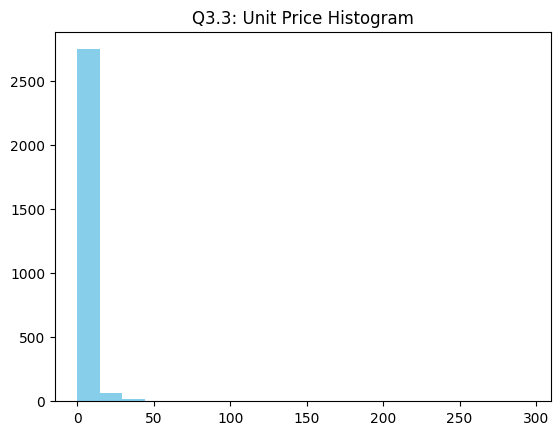

In [91]:
# to merge, need to do some cleaning on the item code in the purchases df
purchases['StockCode'] = purchases['StockCodeSC'].str.replace(r'[a-zA-Z%]', '', regex=True)
# print(purchases.head())
# now we can merge with items
items_purchases = pd.merge(purchases, items, on='StockCode')
# print(items_purchases.head())
# create a unique items df
unique_items = items_purchases.drop_duplicates('StockCode')
# print(unique_items.head())
# calculate mean UnitPrice
avg_unit_price = unique_items['UnitPrice'].mean()
# print output
print(f'\nQ3.1: Average Unit Price: {avg_unit_price:.2f}')

# define function to return 1/0 based on unit price
def under25(x):
    if x < 25:
        return 1
    else:
        return 0

# apply to the unique items df in a new column called under25
unique_items['Under25'] = unique_items['UnitPrice'].apply(under25)
# print output
# print(unique_items.head())
# calculate the percentage of items under $25
pct_under25 = unique_items['Under25'].mean()
# print output
print(f'\nQ3.2: Percentage of items under $25: {pct_under25:.2%}\n')

## generate a histogram of unit prices
# set plot params 
max_x = unique_items['UnitPrice'].max()
min_x = unique_items['UnitPrice'].min()
# print(max_price)
plt.hist(unique_items['UnitPrice'], bins=20, 
    color='skyblue', range=(min_x, max_x))
plt.title('Q3.3: Unit Price Histogram')

Q3.3: The percentage under $25 calculation shows that 98% of the items are priced less than $25. The histogram shows that there are only a few items priced much more than $50. I used the minimum and maximum of the `UnitPrice` field to determine the range of the histogram. The `max_x` object is the maximum value of the `UnitPrice` field, which evalutes to 250. Below is a histogram with a max value of 30, which allows us to see the distribution of the majority of the items.

Text(0.5, 1.0, 'Q3.3: Unit Price Histogram excluding large values')

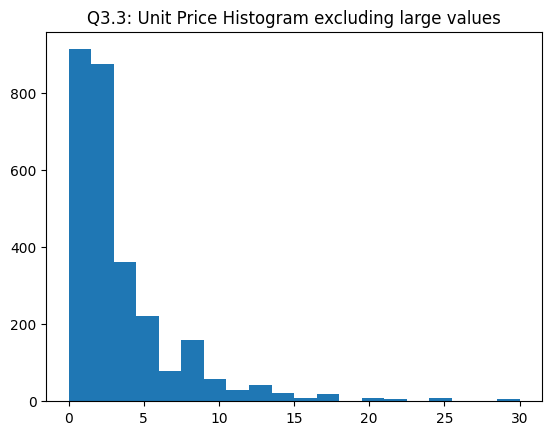

In [92]:
plt.hist(unique_items['UnitPrice'], bins=20, range=(0, 30))
plt.title('Q3.3: Unit Price Histogram excluding large values')

### <span style="color:magenta"> Q4. [25 points] Order Trends </span>
1. What are the top 10 most ordered items? Describe them. Do you see any trends?  
1. What are the top 5 invoices that generated the most revenue? (Revenue is calculated by "marking up" the unit price by 25%.) 
1. Do the top 5 invoices contain any of the top 10 most ordered items?

_Hint: When calculating the revenue we suggest adding a new column on the dataframe._

In [93]:
# output top 10 ordered items by quantity
top_10_items = items_purchases.groupby(['Description']).agg({'Quantity':'sum'}). \
    sort_values(by='Quantity', ascending=False).head(10).reset_index()
# print output
print(f'\nQ4.1: Top 10 items by quantity: \n {top_10_items}')

# top 5 invoices by revenue
# 1. merge invoices and items to get items and prices in the same df
# 2. calculate revenue for each item (unit price * quantity)
# 3. sum revenue for each invoice
# 4. sort and output top 5
# invoices.head() # InvoiceNo	InvoiceDate	CustomerID	Country
# items.head() # StockCode	Description	UnitPrice
# purchases.head() # InvoiceNo	StockCodeSC	Quantity	StockCode
invoice_quantities = pd.merge(invoices, purchases, on='InvoiceNo')
# invoice_purchases.head()
# add on prices from items df
invoice_prices_quantities = pd.merge(invoice_quantities, items, on='StockCode')
# invoice_prices_quantities.head()
# calculate (price*1.25) * quantity = Total Item Revenue 
invoice_prices_quantities['Item Revenue'] = (invoice_prices_quantities['UnitPrice']*1.25) * invoice_prices_quantities['Quantity']
# print(invoice_prices_quantities.head())
# sum Revenue by invoice
invoice_revenue = invoice_prices_quantities.groupby('InvoiceNo').agg({'Item Revenue':'sum'}).reset_index()
# print(invoice_revenue.head())
# sort and output top 5
top_5_invoices = invoice_revenue.sort_values(by='Item Revenue', ascending=False).head(5)
# print output
print(f'\nQ4.2: Top 5 invoices by revenue: \n {top_5_invoices}')
# check customer number for top 5 invoices
top_5_customers = pd.merge(top_5_invoices, invoices, on='InvoiceNo')[['CustomerID']].value_counts().reset_index()
# print output
print(f'\nQ4.2: Top 5 customers by revenue: \n {top_5_customers}')



Q4.1: Top 10 items by quantity: 
                           Description  Quantity
0                SMALL POPCORN HOLDER     56450
1   WORLD WAR 2 GLIDERS ASSTD DESIGNS     53847
2       ASSORTED COLOUR BIRD ORNAMENT     36221
3     PACK OF 72 RETROSPOT CAKE CASES     36039
4                  RABBIT NIGHT LIGHT     30646
5             MINI PAINT SET VINTAGE      26437
6          PACK OF 12 LONDON TISSUES      26315
7  PACK OF 60 PINK PAISLEY CAKE CASES     24753
8     VICTORIAN GLASS HANGING T-LIGHT     23854
9                 BROCADE RING PURSE      23053

Q4.2: Top 5 invoices by revenue: 
       InvoiceNo  Item Revenue
18175    581483   210587.0000
1873     541431    96479.5000
7728     556255    34323.7500
7963     556917    33145.4125
10651    563614    32167.2000

Q4.2: Top 5 customers by revenue: 
    CustomerID  count
0     12415.0      2
1     12346.0      1
2     16446.0      1
3     18102.0      1


In [94]:
# compare items in top 5 invoices to top 10 items
# left join top 5 invoices with items
# this is all of the items on the top 5 invoices
top_5_items = pd.merge(top_5_invoices, items_purchases, 
    on='InvoiceNo')[['InvoiceNo', 'Description', 'StockCode', 'Item Revenue']]
# print(top_5_items)
# next left join with top 10 items to see overlap
top_5_top_10 = pd.merge(top_5_items, top_10_items, 
    on='Description')[['Description', 'StockCode']]. \
    drop_duplicates()
# print output
print(f'\nQ4.3: Top Quantity Items that appear on the top 5 invoices: \n {top_5_top_10}')


Q4.3: Top Quantity Items that appear on the top 5 invoices: 
                           Description StockCode
0                  RABBIT NIGHT LIGHT     23084
1             MINI PAINT SET VINTAGE      22492
2     PACK OF 72 RETROSPOT CAKE CASES     21212
3  PACK OF 60 PINK PAISLEY CAKE CASES     21977


The top 10 most ordered items based on quantity are all small toys of some kind. Based on the description, many of the items are "vintage" or "retro" toys.

To determine the top 5 invoices by revenue, I first had to merge the `invoices` and `purchases` dataframes to get the InvoiceNo, Quantity, and StockCode in the same dataframe. Then I merged in the `items` dataframe to get the UnitPrice. It was only after re-reading the question that I understood that Unit Price was a wholesale price, and the 25% markup was the retail price. I calculated the revenue by multiplying the Quantity by the UnitPrice*1.25. 
There were 2 top 5 invoices from the same customer, all others were unique CustomerIDs. The top 5 invoice amounts ranged from over $30,000 to over $210,000.  
To compare the item types that appear on the top 5 invoice, I merged the top 10 items to the top 5 invoices. There were 4 items that appeared in the top 10 items and the top 5 invoices: Rabbit Night Light, Mini Paint Set Vintage, Pack of 72 Retro Spot Cake Cases, and Pack of 60 Pink Paisley Cake Cases. As mentioned, some of these items are specifically described as Vintage or Retro.

### <span style="color:magenta"> Q5. [30 points] Customer Analysis </span>
1. Classify customers into segments based on the total revenue they have generated for the company.
 * low value: less than \$1750  
 * medium value: between 1750 and 8250 dollars
 * high value: greater than \$8250
1. How many customers are in each segment? 
1. Using the pivot table function, create a table that displays the average order quantity of each stock code for a given segment.
1. Are the items with the highest average order quantity generally the same across segments? Explain your reasoning. 
1. Choose three items and discuss any trends/differences you notice across the three segments.

_Hint: When calculating the segment, we suggest constructing a new dataframe as an intermediary step with the columns: CustomerID, Revenue, Segment._

In [95]:
# using previously created table: with revenues by invoice
# calculate total revenue by customer
customer_revenues = pd.merge(invoice_revenue, invoices, on='InvoiceNo'). \
    groupby('CustomerID').agg({'Item Revenue':'sum'}).reset_index()
# define function to return customer category
def customer_category(x):
    if x < 1750:
        return 'Low value'
    elif (x > 1750 and x < 8250):
        return 'Medium value'
    else:
        return 'High value'

# apply to the customer revenues df in a new column called customer category
customer_revenues['Customer Category'] = customer_revenues['Item Revenue'].apply(customer_category)
# count the number of customers in each category
customer_category_counts = customer_revenues['Customer Category'].value_counts().reset_index()
print(f'\nQ5.1: Customer Category Counts: \n {customer_category_counts}')

# average order of each stock code per customer category
# first merge customer_revenues with invoice_quantities
items_per_category = pd.merge(customer_revenues, invoice_prices_quantities, on=['CustomerID'])[['Customer Category', 'StockCode', 'Quantity']]
# calculate average number of items per stock code per customer category
avg_items_per_category = items_per_category.pivot_table(index='StockCode', 
    columns='Customer Category', values='Quantity', aggfunc='mean').reset_index()
# sort by high value customers
avg_items_per_category = avg_items_per_category.sort_values(by='High value', ascending=False)

# print output
print(f'\nQ5.2: Average order of each stock code with each customer category: \n {avg_items_per_category.head()}')

# choose 3 stock codes at random to explore
# first pick 3 values from the avg_items_per_category df
# stock_codes = avg_items_per_category['StockCode'].sample(3).values
stock_codes = ['23550', '23198', '22079']
# then subset avg_items_per_category to only include those stock codes
customer_trends = avg_items_per_category[avg_items_per_category['StockCode'].isin(stock_codes)]
# merge in the item descriptions
customer_trends = pd.merge(customer_trends, items, on='StockCode')[['StockCode', 'Description', 'UnitPrice', 
    'Low value', 'Medium value', 'High value']]
print(f'\nQ5.3: Customer trends for {stock_codes}: \n {customer_trends}')


Q5.1: Customer Category Counts: 
   Customer Category  count
0         Low value   2959
1      Medium value   1151
2        High value    205

Q5.2: Average order of each stock code with each customer category: 
 Customer Category StockCode    High value   Low value  Medium value
2304                  23843  80995.000000         NaN           NaN
2552                  84826   3180.000000   14.785714     43.055556
1910                  23166    946.395062   10.185185     11.238095
2499                  84568    840.000000  452.571429    288.000000
2484                  84422    480.000000    9.500000     11.000000

Q5.3: Customer trends for ['23550', '23198', '22079']: 
   StockCode                     Description  UnitPrice  Low value  \
0     23550          WRAP ALPHABET POSTER         0.42  30.000000   
1     23198  PANTRY MAGNETIC  SHOPPING LIST       1.45   5.271186   
2     22079      RIBBON REEL HEARTS DESIGN        1.65   6.366667   

   Medium value  High value  
0     26.0416

Q5.1: There are 205 high value customers, 1151 medium value customers, and 2959 low value customers.  
Q5.3: The items that the high value customers order the largest numbers of are not generally the same as the items that the low value customers order the largest numbers of. One reason for this could be that thte high value customers are ordering higher priced items. Another could be that in general high value customers and low value customers have differing taste in items.  
Q5.4: I chose 3 random stock codes to compare across the segments. All three items have a Unit Price of less than $2. The average order quantity for WRAP ALPHABET POSTER is similar across low and medium value customers, but is much higher for high value customers. The second item (23198) is PANTRY MAGNETIC SHOPPING LIST. Across customer segments, the average order increases from low to high value customers, ranging from 5.2 to 11.3. The third item (22079) is RIBBON REEL HEARTS DESIGN. This is the most expensive item picked, but the range of the average order quantity is similar across the segments, ranging from 6.3 to 9.3.



# Please submit your completed notebook in .IPYNB and .HTML formats via Canvas